Tool to use ClickHouse database. Its a function to execute any query.

In [1]:
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
import requests

def get_clickhouse_data(query, host=url, connection_timeout=1500):
    """
    Send a SQL query to ClickHouse using multipart/form-data instead of URL params.
    """
    # The 'files' argument makes requests send multipart/form-data automatically
    files = {
        'query': (None, query)  # (filename=None, query as value)
    }

    r = requests.post(
        host,
        files=files,
        timeout=connection_timeout
    )

    if r.status_code == 200:
        return r.text
    else:
        return 'Database returned the following error:\n' + r.text

"""
CH_HOST = 'http://localhost:8123' # default address
import requests

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
  r = requests.post(host, params = {'query': query},
    timeout = connection_timeout)
  if r.status_code == 200:
      return r.text
  else:
      return 'Database returned the following error:\n' + r.text
"""

"\nCH_HOST = 'http://localhost:8123' # default address \nimport requests\n\ndef get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):\n  r = requests.post(host, params = {'query': query}, \n    timeout = connection_timeout)\n  if r.status_code == 200:\n      return r.text\n  else: \n      return 'Database returned the following error:\n' + r.text\n"

Tool named execute_sql, which enables the execution of any SQL query.

In [2]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import Optional

class SQLQuery(BaseModel):
  query: str = Field(description="SQL query to execute")

@tool(args_schema = SQLQuery)
def execute_sql(query: str) -> str:
  """Returns the result of SQL query execution"""
  return get_clickhouse_data(query)

Print the parameters of the created too

In [3]:
print(f'''
name: {execute_sql.name}
description: {execute_sql.description}
arguments: {execute_sql.args}
''')


name: execute_sql
description: Returns the result of SQL query execution
arguments: {'query': {'description': 'SQL query to execute', 'title': 'Query', 'type': 'string'}}



Install langgraph library.

In [4]:
import sys
!{sys.executable} -m pip install langgraph

Define the agent state.

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

# defining agent state
class AgentState(TypedDict):
   messages: Annotated[list[AnyMessage], operator.add]

Define the agent itself.

In [6]:
class SQLAgent:
  # initialising the object
  def __init__(self, model, tools, system_prompt = ""):
    self.system_prompt = system_prompt

    # initialising graph with a state
    graph = StateGraph(AgentState)

    # adding nodes
    graph.add_node("llm", self.call_llm)
    graph.add_node("function", self.execute_function)
    graph.add_conditional_edges(
        "llm",
        self.exists_function_calling,
        {True: "function", False: END}
    )
    graph.add_edge("function", "llm")

    # setting starting point
    graph.set_entry_point("llm")

    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

  def call_llm(self, state: AgentState):
    messages = state['messages']
    # adding system prompt if it's defined
    if self.system_prompt:
        messages = [SystemMessage(content=self.system_prompt)] + messages

    # calling LLM
    message = self.model.invoke(messages)

    return {'messages': [message]}

  def execute_function(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls

    results = []
    for tool in tool_calls:
      # checking whether tool name is correct
      if not tool['name'] in self.tools:
        # returning error to the agent
        result = "Error: There's no such tool, please, try again"
      else:
        # getting result from the tool
        result = self.tools[tool['name']].invoke(tool['args'])

        results.append(
          ToolMessage(
            tool_call_id=tool['id'],
            name=tool['name'],
            content=str(result)
          )
      )
    return {'messages': results}

  def exists_function_calling(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0


Setup credentials.

In [ ]:
import os
os.environ["OPENAI_MODEL_NAME"]=''
os.environ["OPENAI_API_KEY"] = ''

Install dependency.

In [8]:
%pip install -qU langchain-openai

Set prompt and call model.

In [9]:
from langchain_openai import ChatOpenAI
# system prompt
prompt = '''You are a senior expert in SQL and data analysis.
So, you can help the team to gather needed data to power their decisions.
You are very accurate and take into account all the nuances in data.
Your goal is to provide the detailed documentation for the table in database
that will help users.'''
model = ChatOpenAI(model="gpt-4o-mini")
doc_agent = SQLAgent(model, [execute_sql], system_prompt=prompt)

Visualize the agent chain.

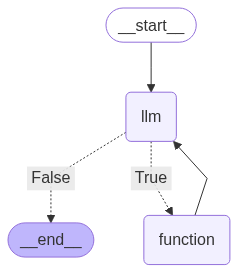

In [10]:
from IPython.display import Image, display

display(Image(doc_agent.graph.get_graph().draw_mermaid_png()))

Call the agent. We get a permission denied error because I don't have write access to the db. Not necessary for proving the agent works.

In [11]:
messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]
result = doc_agent.graph.invoke({"messages": messages})
result['messages']
print(result['messages'][-1].content)

It seems that I'm unable to access the contents or structure of the `ecommerce_db.users` table directly due to permission issues. However, I can provide a standard documentation outline based on typical user tables found in e-commerce databases. You can then customize or fill in the specifics based on your actual database schema.

### Table Documentation: `ecommerce_db.users`

#### Table Overview
The `users` table stores information about users who have registered on the e-commerce platform. This information is crucial for user management, authentication, and personalization.

#### Columns

1. **user_id** (Primary Key)
   - **Type**: Integer / UUID
   - **Description**: Unique identifier for each user.

2. **username**
   - **Type**: String
   - **Description**: The unique username chosen by the user for login.

3. **email**
   - **Type**: String
   - **Description**: The email address of the user, used for communication and password recovery.

4. **password_hash**
   - **Type**: Strin

React agent.

In [42]:
from langgraph.prebuilt import create_react_agent
prebuilt_doc_agent = create_react_agent(model, [execute_sql], prompt = prompt)

Install in-memory sqlite agent.

In [14]:
%pip install langgraph-checkpoint-sqlite

Add persistence with an in-memory SQLite database. Call with a threading and follow-up questions.

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")
with SqliteSaver.from_conn_string(":memory:") as memory:
  prebuilt_doc_agent = create_react_agent(model, [execute_sql], checkpointer=memory)
  # defining thread
  thread = {"configurable": {"thread_id": "1"}}
  messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]
  for event in prebuilt_doc_agent.stream({"messages": messages}, thread):
    for v in event.values():
      v['messages'][-1].pretty_print()
  followup_messages = [HumanMessage(content="I would like to know the column names and types. Maybe you could look it up in database using describe.")]
  for event in prebuilt_doc_agent.stream({"messages": followup_messages}, thread):
    for v in event.values():
      v['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_9TPt96cRR3fYDXlrGaECM78u)
 Call ID: call_9TPt96cRR3fYDXlrGaECM78u
  Args:
    query: SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'users';
================================= Tool Message =================================
Name: execute_sql

Database returned the following error:
<?xml version='1.0' encoding='UTF-8'?><Error><Code>AccessDenied</Code><Message>Access denied.</Message><Details>Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not exist).</Details></Error>
================================== Ai Message ==================================

It seems that there is an access issue preventing me from retrieving the schema information for the `ecommerce_db.users` table directly. However, I can provide a general idea of what inf

Change the thread and ask the same follow-up question. Now without a context manager.

In [23]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)

prebuilt_doc_agent = create_react_agent(model, [execute_sql], checkpointer=memory)
thread = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]
for event in prebuilt_doc_agent.stream({"messages": messages}, thread):
  for v in event.values():
    v['messages'][-1].pretty_print()


new_thread = {"configurable": {"thread_id": "42"}}
followup_messages = [HumanMessage(content="I would like to know the column names and types. Maybe you could look it up in database using describe.")]
for event in prebuilt_doc_agent.stream({"messages": followup_messages}, new_thread):
  for v in event.values():
    v['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_f1EhchJRYxaMwabpK2WzNDYW)
 Call ID: call_f1EhchJRYxaMwabpK2WzNDYW
  Args:
    query: SELECT * FROM ecommerce_db.users LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Database returned the following error:
<?xml version='1.0' encoding='UTF-8'?><Error><Code>AccessDenied</Code><Message>Access denied.</Message><Details>Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not exist).</Details></Error>
================================== Ai Message ==================================

It seems that I'm unable to access the `ecommerce_db.users` table due to permission issues. However, I can help you with the types of information that are typically found in a users table in an e-commerce database. This information of

Multi-agent state.

In [28]:
class MultiAgentState(TypedDict):
  question: str
  question_type: str
  answer: str
  feedback: str


question_category_prompt = '''You are a senior specialist of analytical
support. Your task is to classify the incoming questions.
Depending on your answer, question will be routed to the right team, so your
task is crucial for our team.
There are 3 possible question types:
- DATABASE - questions related to our database (tables or fields)
- LANGCHAIN- questions related to LangGraph or LangChain libraries
- GENERAL - general questions
Return in the output only one word (DATABASE, LANGCHAIN or GENERAL).
'''

def router_node(state: MultiAgentState):
  messages = [
      SystemMessage(content=question_category_prompt),
      HumanMessage(content=state['question'])
          ]
  model = ChatOpenAI(model="gpt-4o-mini")
  response = model.invoke(messages)
  return {"question_type": response.content}

Build graph to test workflow.

In [29]:
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)

builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.set_entry_point("router")
builder.add_edge('router', END)
graph = builder.compile(checkpointer=memory)


Test workflow.

In [30]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({'question': "Does LangChain support Ollama?",}, thread):
  print(s)
  # {'router': {'question_type': 'LANGCHAIN'}}

thread = {"configurable": {"thread_id": "2"}}
for s in graph.stream({'question': "What info do we have in ecommerce_db.users table?",}, thread):
  print(s)
# {'router': {'question_type': 'DATABASE'}}

thread = {"configurable": {"thread_id": "3"}}
for s in graph.stream({'question': "How are you?",}, thread):
  print(s)
# {'router': {'question_type': 'GENERAL'}}

{'router': {'question_type': 'LANGCHAIN'}}
{'router': {'question_type': 'DATABASE'}}
{'router': {'question_type': 'GENERAL'}}


Install dependencies.

In [34]:
%pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


Create nodes for our expert agents.

In [ ]:
# database expert
sql_expert_system_prompt = '''
You are an expert in SQL, so you can help the team
to gather needed data to power their decisions.
You are very accurate and take into account all the nuances in data.
You use SQL to get the data before answering the question.
'''
def sql_expert_node(state: MultiAgentState):
  model = ChatOpenAI(model="gpt-4o-mini")
  sql_agent = create_react_agent(model, [execute_sql],
                                 prompt = sql_expert_system_prompt)
  messages = [HumanMessage(content=state['question'])]
  result = sql_agent.invoke({"messages": messages})
  return {'answer': result['messages'][-1].content}


# search expert
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ["TAVILY_API_KEY"] = ''
tavily_tool = TavilySearchResults(max_results=5)
search_expert_system_prompt = '''
You are an expert in LangChain and other technologies.
Your goal is to answer questions based on results provided by search.
You don't add anything yourself and provide only information baked by other
sources.
'''

def search_expert_node(state: MultiAgentState):
  model = ChatOpenAI(model="gpt-4o-mini")
  sql_agent = create_react_agent(model, [tavily_tool],
                                 prompt = search_expert_system_prompt)
  messages = [HumanMessage(content=state['question'])]
  result = sql_agent.invoke({"messages": messages})
  return {'answer': result['messages'][-1].content}


# general model
general_prompt = '''You're a friendly assistant and your goal is to answer
general questions.
Please, don't provide any unchecked information and just tell that you don't
know if you don't have enough info.
'''

def general_assistant_node(state: MultiAgentState):
  messages = [
      SystemMessage(content=general_prompt),
      HumanMessage(content=state['question'])
      ]
  model = ChatOpenAI(model="gpt-4o-mini")
  response = model.invoke(messages)
  return {"answer": response.content}


Conditional routing.

In [44]:
def route_question(state: MultiAgentState):
  return state['question_type']

Create the graph.

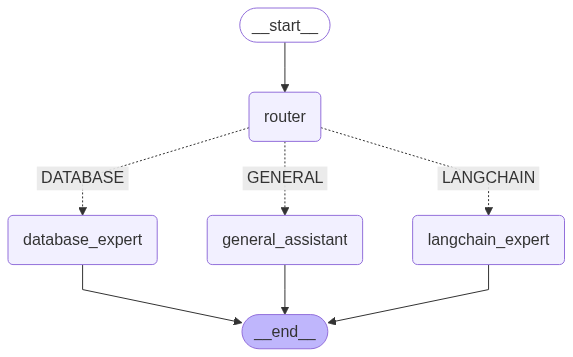

In [45]:
builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.add_node('database_expert', sql_expert_node)
builder.add_node('langchain_expert', search_expert_node)
builder.add_node('general_assistant', general_assistant_node)
builder.add_conditional_edges(
    "router",
    route_question,
     {'DATABASE': 'database_expert',
      'LANGCHAIN': 'langchain_expert',
      'GENERAL': 'general_assistant'}
    )
builder.set_entry_point("router")
builder.add_edge('database_expert', END)
builder.add_edge('langchain_expert', END)
builder.add_edge('general_assistant', END)
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

See how the new graph performs and test on a couple of questions.

In [47]:
thread = {"configurable": {"thread_id": "2"}}
results = []
for s in graph.stream({'question': "What info do we have in ecommerce_db.users table?",}, thread):
  print(s)
  results.append(s)
print(results[-1]['database_expert']['answer'])

thread = {"configurable": {"thread_id": "42"}}
results = []
for s in graph.stream({'question': "Does LangChain support Ollama?",}, thread):
  print(s)
  results.append(s)
print(results[-1]['langchain_expert']['answer'])

{'router': {'question_type': 'DATABASE'}}
{'database_expert': {'answer': "It seems that I do not have access to the database to retrieve the structure or information from the `ecommerce_db.users` table directly. However, typically a users table in an e-commerce database might contain the following columns:\n\n- `user_id`: A unique identifier for the user.\n- `username`: The name chosen by the user for login.\n- `email`: The user's email address.\n- `password_hash`: A hashed representation of the user's password.\n- `created_at`: The date and time when the account was created.\n- `updated_at`: The date and time when the account information was last updated.\n- `first_name`: The user's first name.\n- `last_name`: The user's last name.\n- `address`: The user's shipping address.\n- `phone_number`: The user's contact number.\n- `is_active`: A status indicating whether the user account is active.\n\nIf you have specific access to your database or need help with something else, please let me 

Create human node.

In [49]:
def human_feedback_node(state: MultiAgentState):
  pass

editor_prompt = '''You're an editor and your goal is to provide the final
answer to the customer, taking into account the feedback.
You don't add any information on your own. You use friendly and professional
tone.
In the output please provide the final answer to the customer without
additional comments.
Here's all the information you need.
Question from customer:
----
{question}
----
Draft answer:
----
{answer}
----
Feedback:
----
{feedback}
----
'''

def editor_node(state: MultiAgentState):
  messages = [
      SystemMessage(
          content=editor_prompt.format(
              question=state['question'],
              answer = state['answer'],
              feedback = state['feedback']
              )
          )
      ]
  model = ChatOpenAI(model="gpt-4o-mini")
  response = model.invoke(messages)
  return {"answer": response.content}


Add the human node to the graph with a pause for feedback.

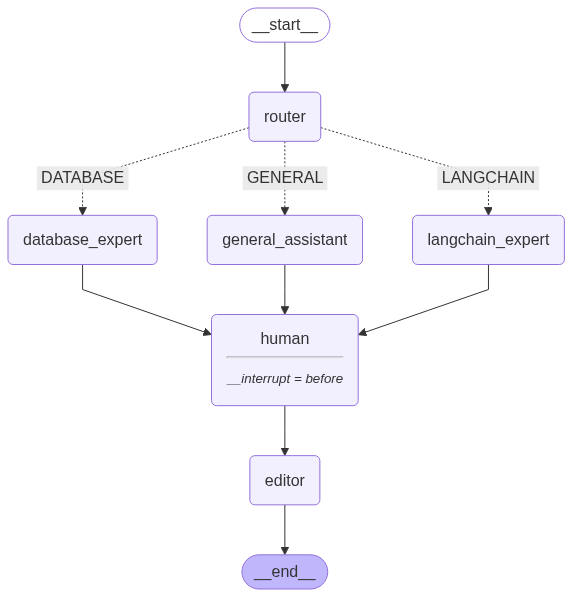

In [50]:
builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.add_node('database_expert', sql_expert_node)
builder.add_node('langchain_expert', search_expert_node)
builder.add_node('general_assistant', general_assistant_node)
builder.add_node('human', human_feedback_node)
builder.add_node('editor', editor_node)
builder.add_conditional_edges(
    "router",
    route_question,
     {'DATABASE': 'database_expert',
      'LANGCHAIN': 'langchain_expert',
      'GENERAL': 'general_assistant'}
    )
builder.set_entry_point("router")
builder.add_edge('database_expert', 'human')
builder.add_edge('langchain_expert', 'human')
builder.add_edge('general_assistant', 'human')
builder.add_edge('human', 'editor')
builder.add_edge('editor', END)
graph = builder.compile(checkpointer=memory, interrupt_before = ['human'])
display(Image(graph.get_graph().draw_mermaid_png()))

Run the human feedback graph.

In [51]:
thread = {"configurable": {"thread_id": "2"}}
for event in graph.stream({'question': "What are the types of fields in ecommerce_db.users table?",}, thread):
  print(event)
user_input = input("Do I need to change anything in the answer?")
graph.update_state(thread, {"feedback": user_input}, as_node="human")
print(graph.get_state(thread).values['feedback'])
print(graph.get_state(thread).next)
for event in graph.stream(None, thread, stream_mode="values"):
  print(event)
  print(event['answer'])

{'router': {'question_type': 'DATABASE'}}
{'database_expert': {'answer': 'It seems that I do not have access to the `ecommerce_db` database to retrieve the structure of the `users` table. You may need to check the database directly or inquire with your database administrator for the specifics of the fields in that table. If you have other questions or need assistance with something else, feel free to ask!'}}
{'__interrupt__': ()}
Do I need to change anything in the answer?

('editor',)
{'question': 'What are the types of fields in ecommerce_db.users table?', 'question_type': 'DATABASE', 'answer': 'It seems that I do not have access to the `ecommerce_db` database to retrieve the structure of the `users` table. You may need to check the database directly or inquire with your database administrator for the specifics of the fields in that table. If you have other questions or need assistance with something else, feel free to ask!', 'feedback': ''}
It seems that I do not have access to the 

Implement human-in-the-loop interactions in a more agentic way.

In [54]:
from langchain_community.tools import HumanInputRun
human_tool = HumanInputRun()

editor_agent_prompt = '''You're an editor and your goal is to provide the final
answer to the customer, taking into the initial question.
If you need any clarifications or need feedback, please, use human. Always
reach out to human to get the feedback before final answer.
You don't add any information on your own. You use friendly and professional
tone.
In the output please provide the final answer to the customer without
additional comments.
Here's all the information you need.
Question from customer:
----
{question}
----
Draft answer:
----
{answer}
----
'''

def editor_node(state: MultiAgentState):
  model = ChatOpenAI(model="gpt-4o-mini")
  editor_agent = create_react_agent(model, [human_tool])
  messages = [
      SystemMessage(
          content=editor_agent_prompt.format(
              question=state['question'],
              answer=state['answer']
              )
          )
      ]
  editor_result = editor_agent.invoke({"messages": messages})
  print(editor_result['messages'][-1].content)
  return {'answer': editor_result['messages'][-1].content}

Add in editor node with q/a feedback.

In [56]:
def editor_agent_node(state: MultiAgentState):
  model = ChatOpenAI(model="gpt-4o-mini")
  editor_agent = create_react_agent(model, [human_tool])
  messages = [SystemMessage(content=editor_agent_prompt.format(question =state['question'], answer = state['answer']))]
  result = editor_agent.invoke({"messages": messages})
  return {'answer': result['messages'][-1].content}

builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.add_node('database_expert', sql_expert_node)
builder.add_node('langchain_expert', search_expert_node)
builder.add_node('general_assistant', general_assistant_node)
builder.add_node('editor', editor_agent_node)
builder.add_conditional_edges(
    "router",
    route_question,
     {'DATABASE': 'database_expert',
      'LANGCHAIN': 'langchain_expert',
      'GENERAL': 'general_assistant'}
    )
builder.set_entry_point("router")
builder.add_edge('database_expert', 'editor')
builder.add_edge('langchain_expert', 'editor')
builder.add_edge('general_assistant', 'editor')
builder.add_edge('editor', END)

graph = builder.compile(checkpointer=memory)
thread = {"configurable": {"thread_id": "42"}}
results = []
for event in graph.stream({'question': "What are the types of fields in ecommerce_db.users table?",}, thread):
  print(event)
results.append(event)


{'router': {'question_type': 'DATABASE'}}
{'database_expert': {'answer': "It seems that I currently don't have the necessary permissions to access the database schema details for the `ecommerce_db.users` table. \n\nTo gather this information, you might want to check directly with your database administrator or use a database management tool that you have access to in order to run the necessary SQL query:\n\n```sql\nSELECT column_name, data_type, is_nullable \nFROM information_schema.columns \nWHERE table_name = 'users';\n```\n\nThis query will provide you with the column names, data types, and nullability of each field in the `users` table. If you have any other questions or need assistance with SQL queries, feel free to ask!"}}


Is the draft answer appropriate for the customer inquiry, or should I make any revisions or add more details?
yes
{'editor': {'answer': "It seems that I currently don't have the necessary permissions to access the database schema details for the `ecommerce_db

Print the final graph.

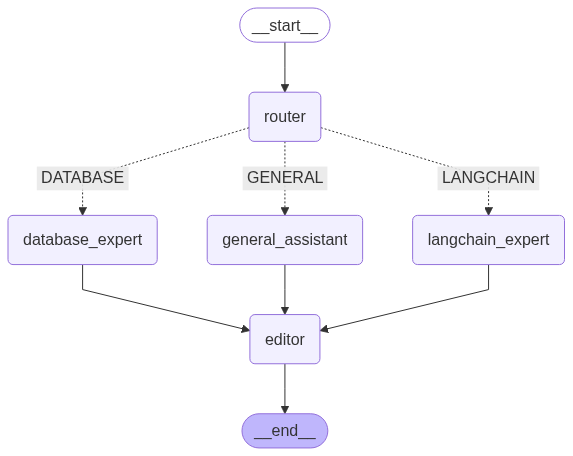

In [57]:
display(Image(graph.get_graph().draw_mermaid_png()))